<a href="https://colab.research.google.com/github/cfparr/TalkInstrument/blob/main/Copia_di_Granello_Parra_HW1_SASP_13_04_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Put the files in your own Google Drive
from google.colab import drive
drive.mount('/content/drive')
filename_1 = '/content/drive/MyDrive/speech.wav'
filename_2 = '/content/drive/MyDrive/piano.wav'


Mounted at /content/drive


In [2]:
#to import and load audio samples
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
from scipy import signal


fs_in, input = wavfile.read(filename_1)

fs_filter, filter = wavfile.read(filename_2)

#trimming audio to test fast
#input = input[1:fs_in*5]

#files have the same sampling rate
fs = min(fs_in, fs_filter)
input = signal.resample(input, (len(input)//fs_in)*fs)
filter = signal.resample(filter, (len(filter)//fs_filter)*fs)

#input and modulator to same length
filter = filter [:min(len(input), len(filter))]
input = input [:min(len(input), len(filter))]

#if there are two channels, just use one
if len(filter.shape) > 1:
    filter = filter[:,0]
if len(input.shape) > 1:
    input = input [:,0]
    
#normalize signals
filter = filter /(np.max(filter))
input = input /(np.max(input))


print(len(input))
print(len(filter))
Audio(input, rate=fs)



837900
837900


In [3]:

#window functions
# we use the bartlett window in this code.

def get_hamming(L):
    #coefficients for hamming window
    #reconstruction sounds clippy
    return 0.54 - (0.46*np.cos(2*np.pi*np.arange(L)/L))

def get_bartlett(L):
    #coefficients for bartlett/triangular window.
    #L: Length of the window
    #window should have 50%
    half = 2* np.arange(L//2) / L
    return np.concatenate((half, np.flip(half)))

def get_hanning(L):
    #returns coefficients for hanning window of length L
    return 0.5* (1-np.cos(2*np.pi*np.arange(L)/L+1))


In [4]:
#STFT functions
def get_windowed_signal(signal, L, R, w=None):
    """
    Partitions signal into windows of length M, separated by R samples
    returns: M x N matrix, where M is the window size, and N is number of windows
    """ 
    xms = np.array([np.zeros(L)]).T  # ini
    ws = w(L) if w is not None else None
    signal = np.concatenate([np.zeros(L//2), signal, np.zeros(L//2)])  # for COLA reconstruction
        # TODO: do we need to strip these zeros in istft?
    ms = range(0, len(signal), R)
    for m in ms:
        xm = signal[m:m+L].copy()
        if len(xm) < L:
            xm = np.concatenate([xm, np.zeros(L-len(xm))])
        if ws is not None:  # apply window fn
            xm *= ws
        xm = np.array([xm]).T
        xms = np.hstack([xms,xm])
    return xms[:, 1:]  # discard first column of all zeros


def get_stft(windowed_signal, nfft=None):
    """
    :param windowed_signal: windowed signal matrix
    :param nfft: the size of the fft.
    
    :return 2-D matrix where each column is a single fft frame 
    """
    if nfft is None:
        nfft = windowed_signal.shape[0]
    ms = windowed_signal.shape[1]
    ffts = np.array([np.zeros(nfft)]).T
    for m in range(ms):
        xm = windowed_signal[:, m]
        freq_window = np.array([np.fft.fft(xm, nfft)]).T
        ffts = np.hstack([ffts, freq_window])
    return ffts[:, 1:]


def get_istft(stft, R):
    """ 
    Performs Overlap-Add reconstruction of original signal
    """
    nfft = stft.shape[0]  # size of the fft
    num_frames = stft.shape[1]  # number of fft windows
    signal = np.zeros((R * (num_frames - 1)) + nfft)
    for m in range(num_frames):
        idx = m*R
        windowed_signal = (np.fft.ifft(stft[:, m])).real
        signal[(idx):idx+nfft] += windowed_signal
    return signal #* (1/nfft)


def plot_spectrogram(stft, fs, R, title="", colorbar=False):    
    """
    plot spectrogram of stft
    """
    plt.figure(figsize=[10,5])
    L = stft.shape[0]
    num_frames = stft.shape[1]
    # we only look at FFT freq up to nyquist limit fs/2, and normalize out imag components
    stft_db = 20*np.log10(np.abs(stft[:L//2, :])*2)
    plt_spec = plt.imshow(
        stft_db,
        origin='lower'
    )
    
    ## create ylim
    num_yticks = 10
    ks = np.linspace(0, L/2, num_yticks)
    ks_hz = ks * fs // (L)
    plt.yticks(ks,ks_hz)
    plt.ylabel("Frequency (Hz)")

    ## create xlim
    num_xticks = 10
    ts_spec = np.linspace(0, num_frames, num_xticks)
    ts_spec_sec  = ["{:4.2f}".format(i) for i in np.linspace(0, (R*num_frames)/fs, num_xticks)]
    plt.xticks(ts_spec,ts_spec_sec)
    plt.xlabel("Time (sec)")

    plt.title(f"{title} L={L} hopsize={R}, fs={fs} Spectrogram.shape={stft.shape}")
    if colorbar:
        plt.colorbar(None, use_gridspec=True)
    plt.show()
    return(plt_spec)


In [5]:
#LPC functions
from scipy.linalg import toeplitz
from scipy.signal import correlate, correlation_lags

def gen_autocorrelates(x, M):
   # returns the autocorrelation coefficients [r_0, r_1, ..., r_M]
   
    rx = np.zeros(M+1)
    for i in range(M+1):
        rx[i] = np.dot(x[:len(x)-i],x[i:])
    return rx


def gen_toeplitz(rx, M):
    covmatrix = np.zeros((M,M))
    for i in range(0,M):
        for j in range(0,M):
            covmatrix[i, j] = rx[np.abs(i-j)]
    return covmatrix


def gen_lp_coeffs(x, M):
   #To efficiently compute the LPC coefficients, we use the Levinson-Durbin recursion 
   #(fast algorithm exploiting the Toeplitz structure of the auto-correlation matrix
    """
    returns a_0, a_1, ... a_M for a signal x
    """
    rx = gen_autocorrelates(x, M)
    toeplitz = gen_toeplitz(rx, M)          
    coeffs, _, _, _ = np.linalg.lstsq(
        toeplitz,
        -1*rx[1:], 
        rcond=None
    )
    return np.concatenate(([1], coeffs))

def gen_lp_coeffs_gradient_descent(x, M):
   #To efficiently compute the LPC coefficients, we use the Levinson-Durbin recursion 
   #(fast algorithm exploiting the Toeplitz structure of the auto-correlation matrix
    """
     returns a_0, a_1, ... a_M for a signal x
    """

  #Estimation of the cross-correlation between the input signal and the desired response y
    p_cc = np.correlate(x, x, mode='full')
    p_lags = correlation_lags(len(x), len(x), mode='full')
    p_cc = np.flipud(p_cc)

  #Build cross-correlation matrix
    p_cc = p_cc[p_lags >= 0] # Take positive lags 0,...,p
    p = p_cc[:M]
    #p = 1/len(x) * p_cc[:M]
    R = toeplitz(p)
    w_o = np.linalg.solve(R, p)
  #Eigenvalues of the autocorrelation matrix
    num_steps = 1000
    eigenvalues = np.linalg.eigvals(R)

    factor = 0.95

    mu = factor * (2/max(eigenvalues)) # Update step

    tau = 1 / (2 * mu * min(eigenvalues))
    w = np.zeros((M,1)) # Initial guess of the filter coefficients: we don't have any prior knowledge so we set it to null vector

    for n in range(num_steps):
         #Perform the iterative update
         w = w + mu*(p - np.dot(R,w))
    
    # Compute the theoretical minimum MSE
    J_min = np.var(input) - np.dot(p.T, np.linalg.solve(R, p))
    #print('Theoretical minimum MSE:')
    #print(J_min)

  # Compute the MSE associated with the current taps estimate
    J_w = J_min + np.dot((w - w_o).T, np.dot(R, (w - w_o)))
    #print('Actual minimum MSE:')
    #print(J_w)

  # Compute and discuss the cost functions ratio
    ratio = J_w / J_min
    #print('Cost function ratio:')
    #print(ratio)
    
    return np.append([1], [w])


def gen_lpc_spec_envs(boole,windowed_input, M, nfft):
    #This function returns a matrix of spectral envelopes,where column m 
    #is spectral envelope for m'th signal frame
    
    #Parameters of the function:
    #windowed_input: In this matrix , each column is a windowed signal.
    #M: Defines the order of linear predictor.
    #nfft: Defines the fft size.
  
      num_frames = windowed_input.shape[1]
      spec_envs = np.array([np.zeros(nfft)]).T
      for m in range(num_frames):
          xm = windowed_input[:, m]  # get mth column
    
          if boole==1:
                coeffs = gen_lp_coeffs(xm, M)
          else: 
                coeffs = gen_lp_coeffs_gradient_descent(xm, M)

          spec_env = np.array([1/(np.abs(np.fft.fft(coeffs, nfft)))]).T
          spec_envs = np.hstack([
          spec_envs, 
          spec_env
          ])
      return spec_envs[:, 1:]
    

In [6]:
#cross-Synthesis

def cross_synthesize(boole,fs, filter, input, L, R, M, flatten=False, w=None, plot=False):
    
    #fs sample rate
    #filter  filter signal in time
    #input input signal in time
    #L window size
    #R hop size
    #M number of coefficients
    #flatten: if true, divide carrier spectrum by its own envelope
    #w window coefficients
    #plot if true, will generate spectrograms
    
    """
    returns stft of cross-synthesized signal, and cross-synthesized audio signal
    """
    # to prevent time-domain aliasing, make nfft size double the window size
    nfft = L*2  # convolution length of two length-L signals, the whitening filter and windowed signal
    
    windowed_filter= get_windowed_signal(filter, L, R, w=w)
    windowed_input = get_windowed_signal(input, L, R, w=w)
    
    filter_STFT = get_stft(windowed_filter, nfft)
    input_STFT = get_stft(windowed_input, nfft)
    if plot:
        plot_spectrogram(filter_STFT, fs, R, title="original filter")
        plot_spectrogram(input_STFT, fs, R, title="input")
    
    # Optional: divide spectrum of filter frame by its own envelope 
    if flatten:
        filter_spec_envs = gen_lpc_spec_envs(boole,windowed_filter, M, nfft)
        filter_STFT = filter_STFT / filter_spec_envs
        if plot: 
            plot_spectrogram(filter_STFT, fs, R, title="flattened filter")
    
    # Multiply filter spectral frame by input spectral envelops
    input_spec_envs = gen_lpc_spec_envs(boole,windowed_input, M, nfft)
    cross_STFT = filter_STFT * input_spec_envs
    if plot: 
        plot_spectrogram(cross_STFT, fs, R, title="cross-synthesized filter")
    
    return cross_STFT, get_istft(cross_STFT, R)

<ipython-input-4-849529e97730>:63: RuntimeWarning: divide by zero encountered in log10
  stft_db = 20*np.log10(np.abs(stft[:L//2, :])*2)


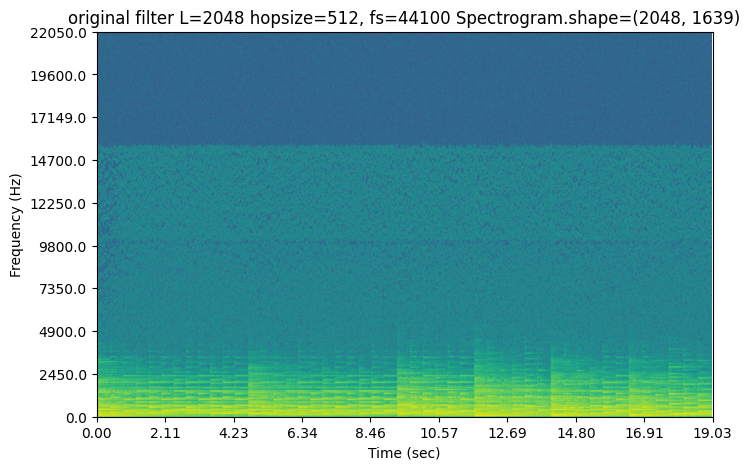

<ipython-input-4-849529e97730>:63: RuntimeWarning: divide by zero encountered in log10
  stft_db = 20*np.log10(np.abs(stft[:L//2, :])*2)


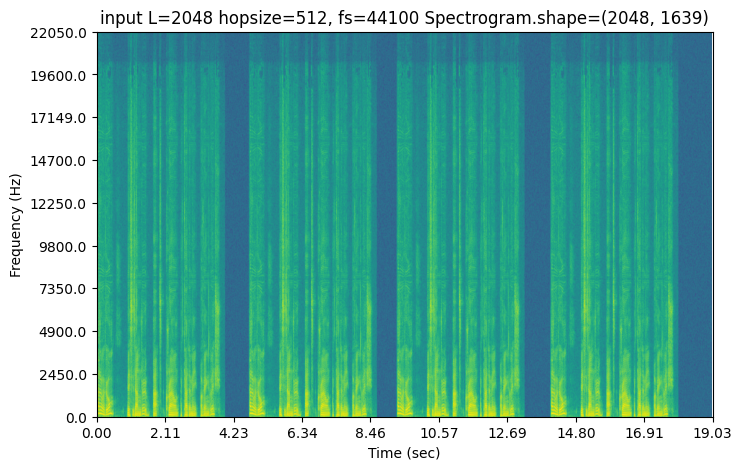

Output streaming troncato alle ultime 5000 righe.
  -2.62143249e-01 -5.26435235e-01]
 [-1.27509146e+02  9.87527027e-02  7.30854664e-03 -1.43616203e-01
  -3.52049532e-01 -6.15215299e-01]
 [-1.26759405e+02 -5.28179294e-02 -1.43616203e-01 -2.93474950e-01
  -5.00436086e-01 -7.61743077e-01]
 [-1.25723980e+02 -2.62143249e-01 -3.52049532e-01 -5.00436086e-01
  -7.05364061e-01 -9.64104006e-01]
 [-1.24416665e+02 -5.26435235e-01 -6.15215299e-01 -7.61743077e-01
  -9.64104006e-01 -1.21960282e+00]]
Cost function ratio:
[[-2.37550868e+01  5.99061703e+00  5.96935068e+00  5.93425148e+00
   5.88577802e+00  5.82457593e+00]
 [ 5.99061703e+00 -8.92240128e-03 -4.62311553e-03  2.47267551e-03
   1.22722568e-02  2.46451068e-02]
 [ 5.96935068e+00 -4.62311553e-03 -3.42150185e-04  6.72340381e-03
   1.64812265e-02  2.88013525e-02]
 [ 5.93425148e+00  2.47267551e-03  6.72340381e-03  1.37390528e-02
   2.34279546e-02  3.56610620e-02]
 [ 5.88577802e+00  1.22722568e-02  1.64812265e-02  2.34279546e-02
   3.30216739e-02  

LinAlgError: ignored

In [7]:
##cross-synthesis

M = 6  # num linear coefficients
L = 1024  # window size
R = L // 2  # hop size  #Cola Condition

boole=False  # 1: wiener-hopf , #0: steepest descent

#cross-synthesize using bartlett window with 50% overlap
cross_STFT, cross_AUDIO = \
    cross_synthesize(boole,
        fs,
        filter, 
        input, 
        L, 
        R, 
        M, 
        flatten=True,
        w=get_bartlett,
        plot=True
    )



In [ ]:
#cross-synthesized audio
Audio(cross_AUDIO, rate=fs)


In [ ]:
#to save the audio to a WAV file
wavfile.write("audio_output_zero_3.wav", fs, np.int16(cross_AUDIO * 32767*0.2))